In [52]:
import torch
import torch.nn as nn
#torchvision for dataset
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as dataloader

In [53]:
#transformation for PIL to tensor format
transformation_operation=transforms.Compose([transforms.ToTensor()])

In [54]:
#import dataset
train_dataset=torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=transformation_operation)
val_dataset=torchvision.datasets.MNIST(root='./data',train=False,download=True,transform=transformation_operation)

In [55]:
num_classes=10
batch_size=64
num_channels=1 #black,white channels in mnist dataset images
img_size=28 #28 x28 pixel images
patch_size=7 #each patch of every image is 7 x7
num_patches=(img_size//patch_size)**2
#print(num_patches)
embedding_dim=64
attention_heads= 4
transformer_blocks= 4
learning_rate=0.001
epochs=5
mlp_hidden_nodes=128

In [56]:
#Define dataset patches

train_loader=dataloader.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader=dataloader.DataLoader(val_dataset,batch_size=batch_size,shuffle=True)


In [57]:
import torch.nn as nn

# Part-1: Patching the Embedding - Created using Convolutions
class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = nn.Conv2d(
            in_channels=num_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        # patch embedding
        x = self.patch_embed(x)

        # flattening the last 2 dimensions (patch dimensions eg: 4x4 patches
        # which is in 2 dimensions flattened to 16 patches in one dimension)
        x = x.flatten(2)

        # arrange output embedding dimension based on no of patches
        # (from: B, C, N → B, N, C)
        x = x.transpose(1, 2)

        return x

In [58]:
#Sample the data point from train_loader

data_point,label=next(iter(train_loader))

print("Shape of data point: ",data_point.shape)
# 64,1,28,28(batch_size,no_of_channel,image_height,image_width)-64 images each with 1 color channel with 28 x 28 pixels

patch_embed=nn.Conv2d(num_channels,embedding_dim,kernel_size=patch_size,stride=patch_size)

patch_embed_output=patch_embed(data_point)
print(patch_embed(data_point).shape)
# 64,64,4,4(batch_size,output_dim,each_patch_height,each_ patch_width) - 64 images with each image having 64 embedding dimensions with 4 x 4 patches of 28 x 28 pixel image

patch_embed_output_flatten=patch_embed_output.flatten(2)
print(patch_embed_output_flatten.shape)
# 64,64,16(batch_size,output_dim,num_patches)

#arrange based on patches-each patch having 64 dimension embedding vector
print(patch_embed_output_flatten.transpose(1,2).shape)

Shape of data point:  torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 4, 4])
torch.Size([64, 64, 16])
torch.Size([64, 16, 64])


In [59]:
class TransformerEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)
        self.multihead_attention = nn.MultiheadAttention(embedding_dim, attention_heads,batch_first=True)#consider batch as first dimension
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_hidden_nodes),
            nn.GELU(),
            nn.Linear(mlp_hidden_nodes, embedding_dim),
        )

    def forward(self, x):               # ← must be indented here
        residual1 = x
        x = self.layer_norm1(x)
        x = self.multihead_attention(x, x, x)[0]
        x = x + residual1
        residual2 = x
        x = self.layer_norm2(x)
        x = self.mlp(x)
        x = residual2 + x
        return x

In [60]:
#Part-3: MLP head for classification


class MLP_head(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1=nn.LayerNorm(embedding_dim)
    self.mlp_head=nn.Linear(embedding_dim,num_classes)


  def forward(self,x):
    #output from transformer is normalized again
    x=self.layer_norm1(x)

    #turning the output dimensions into no of classes for classification
    x=self.mlp_head(x)


    return x


In [61]:
class VisionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding = PatchEmbedding()
    #class token- that helps to classify the image from patches
    self.cls_token=nn.Parameter(torch.randn(1,1,embedding_dim))#1,1,embedding_dim - no of images,no of channels,64
    #position embedding
    self.position_embedding=nn.Parameter(torch.randn(1,num_patches+1,embedding_dim))#1,num_patches+1,embedding_dim - no of images, each image is converted into 16 patches(16 tokens)+ 1 class token with each having 64 embedding dimension
    self.transformer_blocks=nn.Sequential(*[TransformerEncoder() for _ in range(transformer_blocks)])
    self.mlp_head=MLP_head()


  def forward(self,x):
    x=self.patch_embedding(x)
    B=x.size(0)#current input batch size
    #one class token for one image in the batch - expanding it for all images
    class_token=self.cls_token.expand(B,-1,-1)#-1,-1 will make the last 2 dimensions same
    #prepend the class tokens to the patches
    x=torch.cat((class_token,x),dim=1)
    #add positional embedding
    x=x+self.position_embedding

    x=self.transformer_blocks(x)

    #pass only the class token embeddinn to the classification ml head
    x=x[:,0]# for every row(each image),taking the 0th column(class token)
    x=self.mlp_head(x)

    return x

In [62]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=VisionTransformer().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion=nn.CrossEntropyLoss()



In [63]:
#training

for epoch in range(epochs):

  model.train()
  total_loss=0
  correct_epoch=0
  total_epoch=0

  print(f"\nEpoch {epoch+1}")

  for batch_idx,(images,labels) in enumerate(train_loader):#labels - correct output for each input
    images,labels=images.to(device),labels.to(device)

    optimizer.zero_grad()

    outputs=model(images)

    loss=criterion(outputs,labels)

    loss.backward()
    optimizer.step()

    total_loss+=loss.item()
    preds=outputs.argmax(dim=1)

    correct=(preds==labels).sum().item()
    accuracy=100.0*correct/labels.size(0)

    correct_epoch+=correct

    total_epoch+=labels.size(0)
    if batch_idx%100==0:
      print(f" Batch {batch_idx+1:3d}: Loss={loss.item():.4f}, Accuracy = {accuracy: .2f}%")

  epoch_acc=100.0*correct_epoch/total_epoch
  print(f"==> Epoch {epoch+1} Summary: Total Loss = {total_loss:.4f}, Accuracy = {epoch_acc:.2f}%")



Epoch 1
 Batch   1: Loss=2.4357, Accuracy =  12.50%
 Batch 101: Loss=0.8767, Accuracy =  75.00%
 Batch 201: Loss=0.1458, Accuracy =  98.44%
 Batch 301: Loss=0.3382, Accuracy =  93.75%
 Batch 401: Loss=0.4114, Accuracy =  89.06%
 Batch 501: Loss=0.2152, Accuracy =  93.75%
 Batch 601: Loss=0.1754, Accuracy =  96.88%
 Batch 701: Loss=0.2915, Accuracy =  87.50%
 Batch 801: Loss=0.1838, Accuracy =  96.88%
 Batch 901: Loss=0.1032, Accuracy =  95.31%
==> Epoch 1 Summary: Total Loss = 341.0818, Accuracy = 88.67%

Epoch 2
 Batch   1: Loss=0.0505, Accuracy =  100.00%
 Batch 101: Loss=0.2799, Accuracy =  93.75%
 Batch 201: Loss=0.2475, Accuracy =  96.88%
 Batch 301: Loss=0.0552, Accuracy =  98.44%
 Batch 401: Loss=0.1372, Accuracy =  95.31%
 Batch 501: Loss=0.2963, Accuracy =  89.06%
 Batch 601: Loss=0.1058, Accuracy =  96.88%
 Batch 701: Loss=0.0191, Accuracy =  100.00%
 Batch 801: Loss=0.0481, Accuracy =  100.00%
 Batch 901: Loss=0.1890, Accuracy =  95.31%
==> Epoch 2 Summary: Total Loss = 120

In [64]:
#Validation mode

model.eval()
correct=0
epoch=0
total=0

with torch.no_grad():
  for images,labels in val_loader:
    images,labels=images.to(device), labels.to(device)
    outputs=model(images)
    pred=outputs.argmax(dim=1)
    correct+=(pred==labels).sum().item()
    total+=labels.size(0)

test_acc=100.0 * correct/total
print(f"Validation Accuracy: {test_acc:.2f}%")

Validation Accuracy: 97.23%


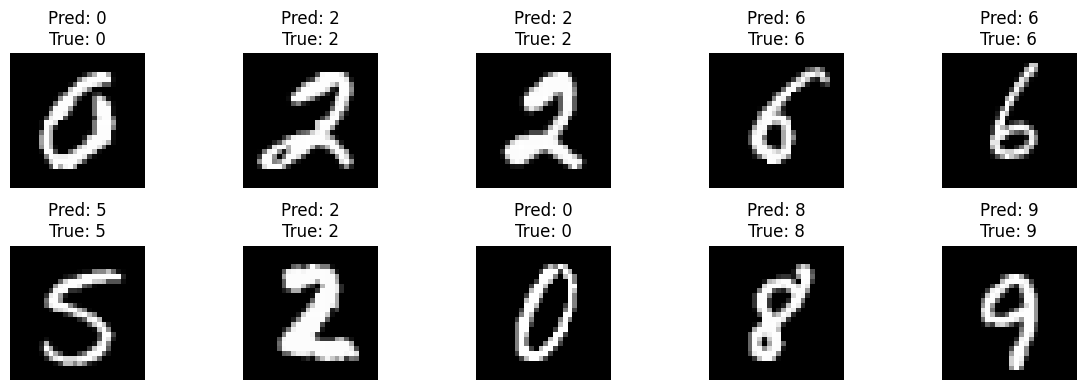

In [65]:
import matplotlib.pyplot as plt

model.eval()

images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Move to CPU for plotting
images = images.cpu()
preds = preds.cpu()
labels = labels.cpu()

# Plot first 10 images
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
    plt.axis("off")

plt.tight_layout()
plt.show()
